# **Imports**

In [ ]:
#!pip install tensorflow==2.5
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

print(tf.__version__)

2.7.0


In [ ]:
import os, pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

# **Data downloads**

In [ ]:
os.environ['KAGGLE_USERNAME'] = "jhao1roshan" 
os.environ['KAGGLE_KEY'] = "765678865dbc0d8e1423d8ac6a727255" 
import kaggle
!kaggle competitions download -c ashrae-energy-prediction

100% 88.4M/88.4M [00:00<00:00, 119MB/s] 

 79% 95.0M/120M [00:00<00:00, 119MB/s] 
100% 120M/120M [00:00<00:00, 204MB/s] 
  0% 0.00/44.5k [00:00<?, ?B/s]
100% 44.5k/44.5k [00:00<00:00, 38.2MB/s]
 96% 160M/167M [00:01<00:00, 134MB/s]
100% 167M/167M [00:01<00:00, 138MB/s]
  0% 0.00/2.53M [00:00<?, ?B/s]
100% 2.53M/2.53M [00:00<00:00, 172MB/s]
  0% 0.00/1.27M [00:00<?, ?B/s]
100% 1.27M/1.27M [00:00<00:00, 180MB/s]


In [ ]:
# Unzip the files
from zipfile import ZipFile
files_path=['/content/weather_train.csv.zip', '/content/train.csv.zip']

for path in files_path:
    with ZipFile(path, 'r') as zip:
        zip.extractall()

In [ ]:
sep=','
path_main='/content/train.csv'
path_meta='/content/building_metadata.csv'
path_weather='/content/weather_train.csv'

In [ ]:
!cat {path_main} | head -5
!cat {path_meta} | head -5
!cat {path_weather} | head -5

building_id,meter,timestamp,meter_reading
0,0,2016-01-01 00:00:00,0.0
1,0,2016-01-01 00:00:00,0.0
2,0,2016-01-01 00:00:00,0.0
3,0,2016-01-01 00:00:00,0.0
site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,Education,7432,2008,
0,1,Education,2720,2004,
0,2,Education,5376,1991,
0,3,Education,23685,2002,
site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,2016-01-01 00:00:00,25.0,6.0,20.0,,1019.7,0.0,0.0
0,2016-01-01 01:00:00,24.4,,21.1,-1.0,1020.2,70.0,1.5
0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0


# **Files loading**

In [ ]:
# Load all the files
data_main=pd.read_csv(path_main, sep=sep, parse_dates=['timestamp'])
# Loading data for single meter
data_main=data_main[data_main.meter==0]

# Removing data of missing records
valid_id=data_main.building_id.value_counts()[data_main.building_id.value_counts()==8784].index
data_main=data_main[data_main.building_id.isin(valid_id)]

data_meta=pd.read_csv(path_meta, sep=sep)
data_weather=pd.read_csv(path_weather, sep=sep, parse_dates=['timestamp'])

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0000
1,1,0,2016-01-01 00:00:00,0.0000
2,2,0,2016-01-01 00:00:00,0.0000
3,3,0,2016-01-01 00:00:00,0.0000
4,4,0,2016-01-01 00:00:00,0.0000
...,...,...,...,...
20215835,1319,0,2016-12-31 23:00:00,0.0000
20215838,1320,0,2016-12-31 23:00:00,74.5519
20215839,1321,0,2016-12-31 23:00:00,584.0000
20215845,1323,0,2016-12-31 23:00:00,172.0000


In [ ]:
# Join the 3 datasets
dataset=pd.merge(data_main,data_meta,on='building_id', how='left')
dataset=dataset.merge(data_weather, on=['site_id', 'timestamp'], how='left') 

cat_cols=['building_id','site_id','meter','primary_use']
dataset[cat_cols]=dataset[cat_cols].astype('category')


# **Data exploration**

In [ ]:
# summary

dataset.describe()

,meter_reading,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,3.715632e+06,3.715632e+06,1.976400e+06,1.273680e+06,3.709938e+06,1.804103e+06,3.709913e+06,2.324003e+06,2.900300e+06,3.616984e+06,3.708316e+06
mean,1.569519e+02,8.537494e+04,1.976262e+03,3.944828e+00,1.400034e+01,2.091929e+00,8.608607e+00,1.020358e+00,1.016553e+03,1.847628e+02,3.926677e+00
std,2.790747e+02,9.506267e+04,2.713355e+01,2.885827e+00,9.792760e+00,2.614317e+00,9.485373e+00,9.529255e+00,7.634707e+00,1.107113e+02,2.351287e+00
min,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,1.200000e+01,2.707100e+04,1.966000e+03,2.000000e+00,7.200000e+00,0.000000e+00,2.800000e+00,0.000000e+00,1.012700e+03,8.000000e+01,2.100000e+00
50%,5.500000e+01,5.743600e+04,1.976000e+03,3.000000e+00,1.400000e+01,0.000000e+00,9.500000e+00,0.000000e+00,1.017100e+03,2.000000e+02,3.600000e+00
75%,1.735890e+02,1.032860e+05,2.000000e+03,6.000000e+00,2.170000e+01,4.000000e+00,1.560000e+01,0.000000e+00,1.021100e+03,2.800000e+02,5.100000e+00
max,5.654510e+03,8.195770e+05,2.016000e+03,1.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01


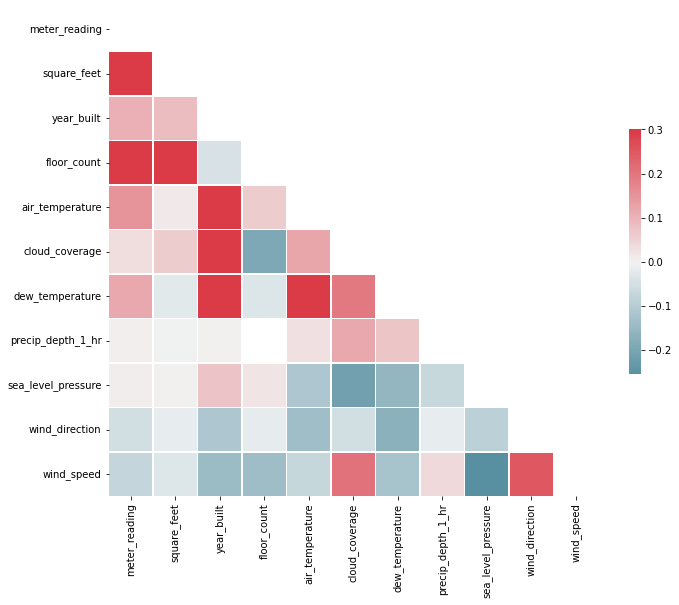

In [ ]:
# Correlation
data_corr=dataset.iloc[:,3:].corr()

mask = np.triu(np.ones_like(data_corr, dtype=np.bool))

f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(data_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

'''
Floor_count and square_feet are good indicators
Both are correlated too'''

In [ ]:
# Null value
dataset.isna().sum()/dataset.shape[0]

''' 
Drop - 'year_built', 'floor_count', 'cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure'
Fill - 'dew_temperature', 'wind_direction', 'wind_speed'
'''

building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
year_built            0.468085
floor_count           0.657210
air_temperature       0.001532
cloud_coverage        0.514456
dew_temperature       0.001539
precip_depth_1_hr     0.374534
sea_level_pressure    0.219433
wind_direction        0.026549
wind_speed            0.001969
dtype: float64

# **Pre-processing**

In [ ]:
# Handle NaN
dataset.drop(columns=['year_built', 'floor_count', 'cloud_coverage', 'precip_depth_1_hr', 'sea_level_pressure'], inplace=True)
dataset.fillna(dataset.median(), inplace=True)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Feature engineering

#1 Let's make wind direction of (180-360) as negative
dataset.wind_direction = dataset.wind_direction.map(lambda x:180-x if x>=180 else x)

In [ ]:
# Create features from Timestamp
dataset["hour"] = dataset["timestamp"].dt.hour
dataset["day"] = dataset["timestamp"].dt.day
dataset["weekend"] = dataset["timestamp"].dt.weekday
dataset["month"] = dataset["timestamp"].dt.month



In [ ]:
# Create sine-cosine features for Time period

hour = 60*60
day = 24*hour
month = (30)*day

timestamp_s = dataset.timestamp.map(pd.Timestamp.timestamp)
dataset['hour_sin'] = np.sin(dataset.hour * (2 * np.pi / hour))
dataset['hour_cos'] = np.cos(dataset.hour * (2 * np.pi / hour))
dataset['day_sin'] = np.sin(dataset.day * (2 * np.pi / day))
dataset['day_cos'] = np.cos(dataset.day * (2 * np.pi / day))
dataset['month_sin'] = np.sin(dataset.month * (2 * np.pi / month))
dataset['month_cos'] = np.cos(dataset.month * (2 * np.pi / month))

dataset.drop(columns=['hour','day','month'], inplace=True)
dataset

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,wind_direction,wind_speed,weekend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos
0,0,0,2016-01-01 00:00:00,0.0000,0,Education,7432,25.0,20.0,0.0,0.0,4,0.000000,1.000000,0.000073,1.000000,0.000002,1.0
1,1,0,2016-01-01 00:00:00,0.0000,0,Education,2720,25.0,20.0,0.0,0.0,4,0.000000,1.000000,0.000073,1.000000,0.000002,1.0
2,2,0,2016-01-01 00:00:00,0.0000,0,Education,5376,25.0,20.0,0.0,0.0,4,0.000000,1.000000,0.000073,1.000000,0.000002,1.0
3,3,0,2016-01-01 00:00:00,0.0000,0,Education,23685,25.0,20.0,0.0,0.0,4,0.000000,1.000000,0.000073,1.000000,0.000002,1.0
4,4,0,2016-01-01 00:00:00,0.0000,0,Education,116607,25.0,20.0,0.0,0.0,4,0.000000,1.000000,0.000073,1.000000,0.000002,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715627,1319,0,2016-12-31 23:00:00,0.0000,14,Entertainment/public assembly,287419,6.1,-6.7,-10.0,9.8,5,0.040132,0.999194,0.002254,0.999997,0.000029,1.0
3715628,1320,0,2016-12-31 23:00:00,74.5519,14,Entertainment/public assembly,34565,6.1,-6.7,-10.0,9.8,5,0.040132,0.999194,0.002254,0.999997,0.000029,1.0
3715629,1321,0,2016-12-31 23:00:00,584.0000,14,Entertainment/public assembly,370024,6.1,-6.7,-10.0,9.8,5,0.040132,0.999194,0.002254,0.999997,0.000029,1.0
3715630,1323,0,2016-12-31 23:00:00,172.0000,14,Office,87200,6.1,-6.7,-10.0,9.8,5,0.040132,0.999194,0.002254,0.999997,0.000029,1.0


In [ ]:
# Create a concatenated String col 
dataset['cat_col']= dataset.site_id.astype(str)+'_'+dataset.building_id.astype(str)+'_'+dataset.primary_use.astype(str)#+'_'+dataset.weekend.astype(str)+'_'+dataset.hour.astype(str)+'_'+dataset.day.astype(str)+'_'+dataset.month.astype(str)
dataset.drop(columns=cat_cols, inplace=True)

dataset

,timestamp,meter_reading,square_feet,air_temperature,dew_temperature,wind_direction,wind_speed,weekend,hour_sin,hour_cos,day_sin,day_cos,month_sin,month_cos,cat_col
0,2016-01-01 00:00:00,0.0000,7432,25.0,20.0,0.0,0.0,4,0.000000,1.000000,0.000073,1.000000,0.000002,1.0,0_0_Education
1,2016-01-01 00:00:00,0.0000,2720,25.0,20.0,0.0,0.0,4,0.000000,1.000000,0.000073,1.000000,0.000002,1.0,0_1_Education
2,2016-01-01 00:00:00,0.0000,5376,25.0,20.0,0.0,0.0,4,0.000000,1.000000,0.000073,1.000000,0.000002,1.0,0_2_Education
3,2016-01-01 00:00:00,0.0000,23685,25.0,20.0,0.0,0.0,4,0.000000,1.000000,0.000073,1.000000,0.000002,1.0,0_3_Education
4,2016-01-01 00:00:00,0.0000,116607,25.0,20.0,0.0,0.0,4,0.000000,1.000000,0.000073,1.000000,0.000002,1.0,0_4_Education
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3715627,2016-12-31 23:00:00,0.0000,287419,6.1,-6.7,-10.0,9.8,5,0.040132,0.999194,0.002254,0.999997,0.000029,1.0,14_1319_Entertainment/public assembly
3715628,2016-12-31 23:00:00,74.5519,34565,6.1,-6.7,-10.0,9.8,5,0.040132,0.999194,0.002254,0.999997,0.000029,1.0,14_1320_Entertainment/public assembly
3715629,2016-12-31 23:00:00,584.0000,370024,6.1,-6.7,-10.0,9.8,5,0.040132,0.999194,0.002254,0.999997,0.000029,1.0,14_1321_Entertainment/public assembly
3715630,2016-12-31 23:00:00,172.0000,87200,6.1,-6.7,-10.0,9.8,5,0.040132,0.999194,0.002254,0.999997,0.000029,1.0,14_1323_Office


In [ ]:
# Convert cat col to Label encoded values
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

dataset.cat_col=le.fit_transform(dataset.cat_col) 
dataset.cat_col.max()

422

In [ ]:
# Train, Test split
y, x = dataset.meter_reading, dataset.drop(columns=['meter_reading'])

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)


In [ ]:
# Preprocess
x_train_num=x_train.iloc[:,1:-1]
x_train_cat=x_train.iloc[:,-1:]

# Separate Num and Cat
x_test_num=x_test.iloc[:,1:-1]
x_test_cat=x_test.iloc[:,-1:]

# Scale
x_mean=x_train_num.mean()
x_std=x_train_num.std()
x_train_num=(x_train_num - x_mean )/x_std
x_test_num=(x_test_num - x_mean )/x_std


In [ ]:
# Create TF Dataset
batch=2048
x_train_num=tf.data.Dataset.from_tensor_slices(x_train_num.to_numpy()).batch(batch)
x_train_cat=tf.data.Dataset.from_tensor_slices(x_train_cat.to_numpy().reshape((-1,1))).batch(batch)
x_test_num=tf.data.Dataset.from_tensor_slices(x_test_num.to_numpy()).batch(batch)
x_test_cat=tf.data.Dataset.from_tensor_slices(x_test_cat.to_numpy().reshape((-1,1))).batch(batch)

y_train=tf.data.Dataset.from_tensor_slices(y_train.to_numpy().reshape((-1,1))).batch(batch)
y_test=tf.data.Dataset.from_tensor_slices(y_test.to_numpy().reshape((-1,1))).batch(batch)
# tf Perf 101
AUTOTUNE = tf.data.experimental.AUTOTUNE
# Train
data_train=tf.data.Dataset.zip(((x_train_cat,x_train_num),y_train))
data_train=data_train.cache().prefetch(buffer_size=AUTOTUNE)
# Test
data_test=tf.data.Dataset.zip(((x_test_cat,x_test_num),y_test))
data_test=data_test.cache().prefetch(buffer_size=AUTOTUNE)

# **Model building**

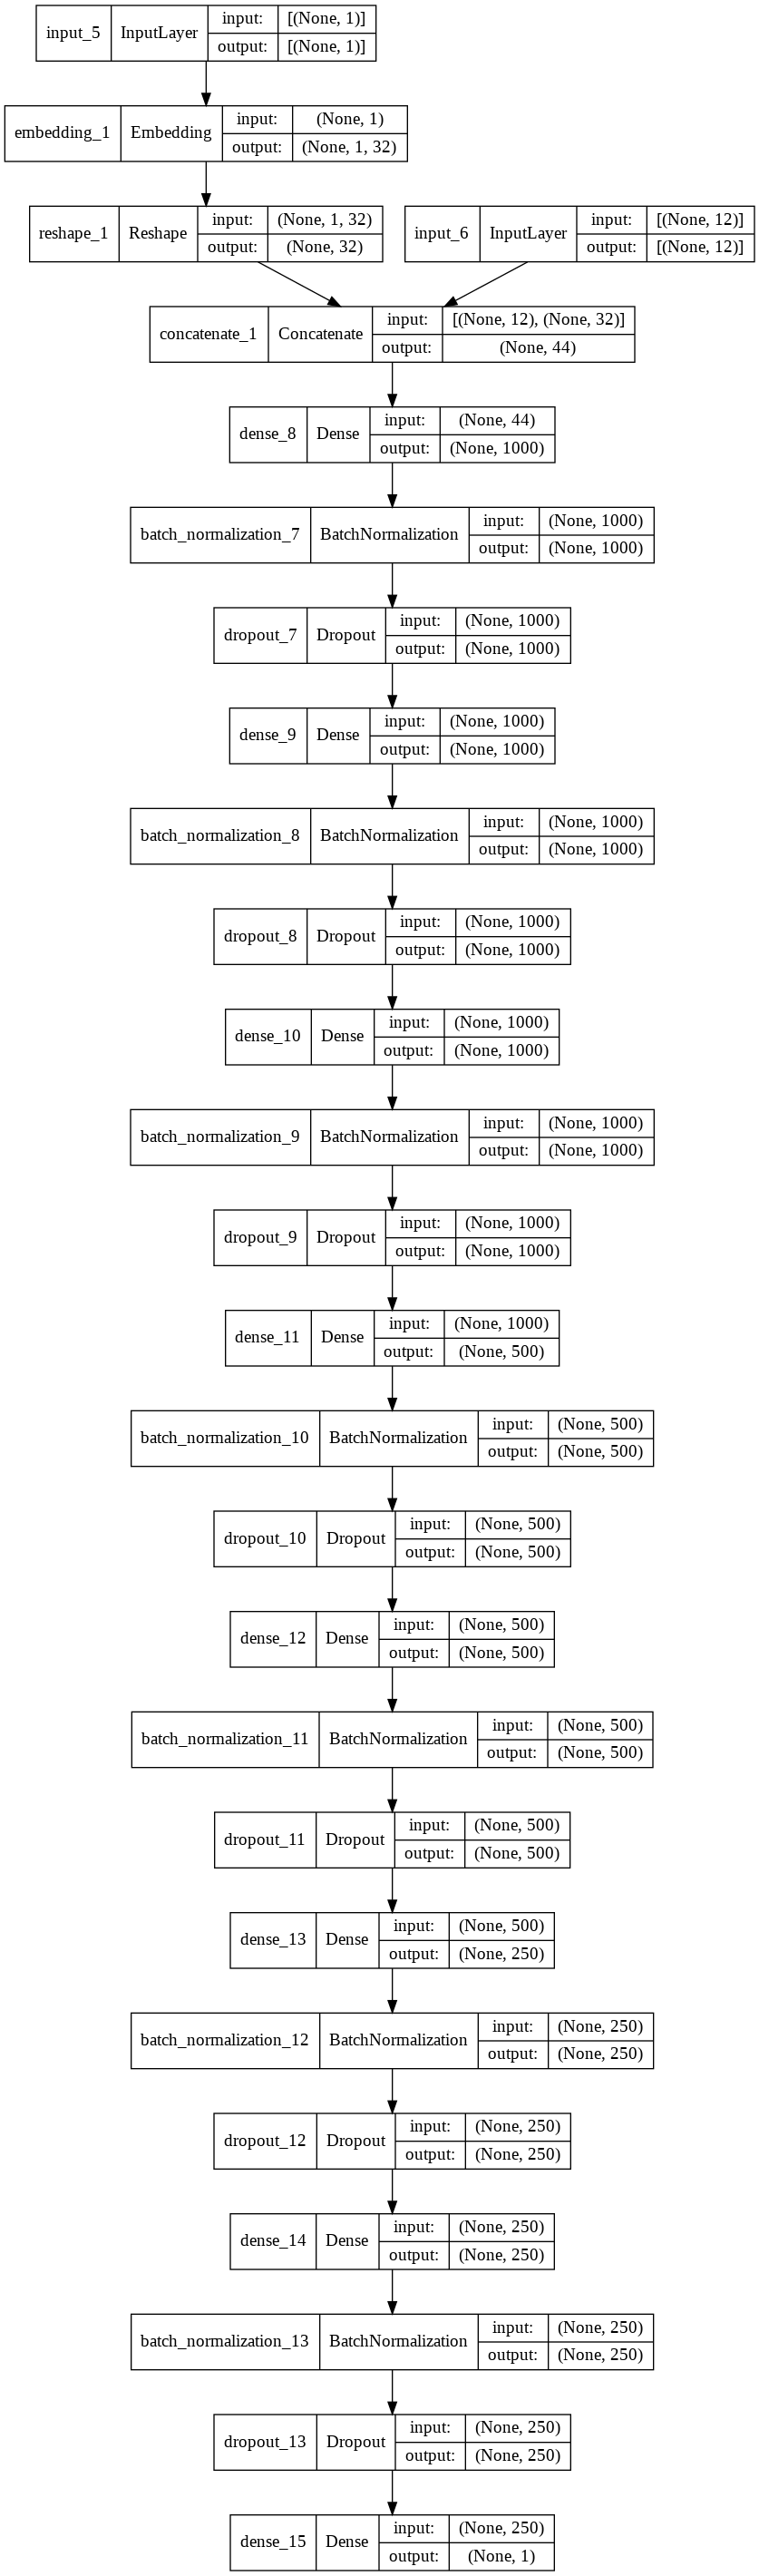

In [ ]:
from tensorflow.keras.layers import Input, Embedding, Reshape, Concatenate, Dense, BatchNormalization, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras as keras

neurons=500
embed_vocab=dataset.cat_col.max()+1
embed_size=32

cat_input = Input(shape=(1,))
num_input = Input(shape=(x_mean.shape))

embed_layer=Embedding(embed_vocab, embed_size)(cat_input)
reshape_layer=Reshape((embed_size,))(embed_layer)
concat_out=Concatenate()([num_input, reshape_layer])

model=Dense(neurons*2, activation='relu')(concat_out)
model=BatchNormalization()(model)
model=Dropout(0.2)(model)
model=Dense(neurons*2, activation='relu')(model)
model=BatchNormalization()(model)
model=Dropout(0.2)(model)
model=Dense(neurons*2, activation='relu')(model)
model=BatchNormalization()(model)
model=Dropout(0.2)(model)
model=Dense(neurons, activation='relu')(model)
model=BatchNormalization()(model)
model=Dropout(0.2)(model)
model=Dense(neurons, activation='relu')(model)
model=BatchNormalization()(model)
model=Dropout(0.2)(model)
model=Dense(neurons//2, activation='relu')(model)
model=BatchNormalization()(model)
model=Dropout(0.2)(model)
model=Dense(neurons//2, activation='relu')(model)
model=BatchNormalization()(model)
model=Dropout(0.2)(model)
model=Dense(1, activation='linear')(model)

model=keras.Model(inputs=[cat_input,num_input], outputs=model)
tf.keras.utils.plot_model(model, show_shapes=True)
#model.summary()

In [ ]:
optimizer=keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,loss='mse')


In [ ]:
model.fit(data_train, 
          validation_data=data_test, 
          epochs=50)

Epoch 1/50
1452/1452 [==============================] - 27s 18ms/step - loss: 3598.2666 - val_loss: 2637.8950
Epoch 2/50
1452/1452 [==============================] - 26s 18ms/step - loss: 3236.0461 - val_loss: 2297.5576
Epoch 3/50
1452/1452 [==============================] - 26s 18ms/step - loss: 3059.0161 - val_loss: 2097.7639
Epoch 4/50
1452/1452 [==============================] - 26s 18ms/step - loss: 2912.7231 - val_loss: 2035.7356
Epoch 5/50
1452/1452 [==============================] - 26s 18ms/step - loss: 2715.7344 - val_loss: 1825.3494
Epoch 6/50
1452/1452 [==============================] - 26s 18ms/step - loss: 2585.4700 - val_loss: 1786.6831
Epoch 7/50
1452/1452 [==============================] - 26s 18ms/step - loss: 2416.9697 - val_loss: 1658.4983
Epoch 8/50
1452/1452 [==============================] - 26s 18ms/step - loss: 2325.6135 - val_loss: 1624.5743
Epoch 9/50
1452/1452 [==============================] - 26s 18ms/step - loss: 2208.7170 - val_loss: 1544.1620
Epoch 10/5

# **Validation**

In [ ]:
# Validate on test data
y_pred=[]
y_true=[]
for x,y in data_test:
    y_p=model(x)
    y_pred=y_pred+list(y_p[:,0].numpy())
    y_true=y_true+list(y[:,0].numpy())

from sklearn.metrics import r2_score
r2_score(y_true, y_pred) #y_true[0:5], y_pred[0:5]

0.9889176303834016

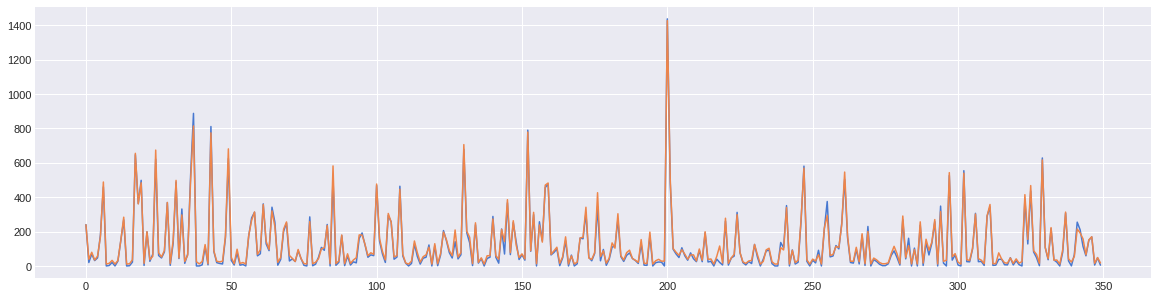

In [ ]:
# Plot y_true vs y_pred
plt.style.use('seaborn-darkgrid')
fig, ax = plt.subplots(1, 1, figsize=(20, 5))

lenth=350
ax.plot(range(len(y_true[:lenth])), y_true[:lenth])
ax.plot(range(len(y_pred[:lenth])), y_pred[:lenth])